# All SPCs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tabulate import tabulate

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

import qda

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from skimage.filters import threshold_otsu

from sklearn.decomposition import PCA

## Helper functions

In [27]:
def check_gaussianity(data_points, title="",plotto=1):
	if str(type(data_points)) == "<class 'pandas.core.series.Series'>":
		data_points = data_points.values
	if plotto==1:
		plt.figure(figsize=(12,4))
		plt.subplot(1, 3, 1)
		stats.probplot(data_points,plot=plt)
		plt.subplot(1, 3, 2)
		plt.hist(data_points)
		plt.subplot(1, 3, 3)
		plt.plot(data_points,'o-')
		plt.suptitle(f"{title}")
		plt.show()
	_, shapiro_pvalue = stats.shapiro(data_points)
	print(f"({title}) Normality p-value = {shapiro_pvalue} - Normality at alpha 5%? {shapiro_pvalue>0.05}")
	print('H0 is "data are not gaussian" => conclusion is good if pvalue is high')

def check_randomness(data_points, title="", plotto=1, layout="h"):
	if plotto==1:
		if layout=="v":
			fig, ax = plt.subplots(3,1, figsize=(8,12))
		else:
			fig, ax = plt.subplots(1,3, figsize=(12,4))
		sgt.plot_acf(data_points, lags = int(len(data_points)/3), zero=False, ax=ax[0])
		fig.subplots_adjust(hspace=0.3)
		sgt.plot_pacf(data_points, lags = int(len(data_points)/3), zero=False, ax=ax[1], method = 'ywm')
		ax[2].plot(data_points,'o-')
		plt.show()	
	_, pval_runs = runstest_1samp(data_points, correction=False)
	print(f'({title}) Runs test p-value = {pval_runs} - Random data at alpha 5%? {pval_runs>0.05}')
	print('H0 is "data are random" => conclusion is good if pvalue is high')

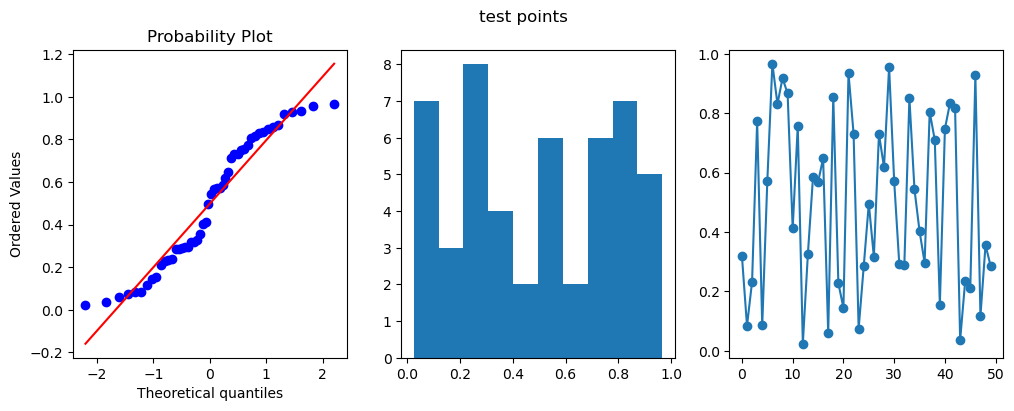

(test points) Normality p-value = 0.004301247652620077 - Normality at alpha 5%? False
H0 is "data are not gaussian" => conclusion is good if pvalue is high


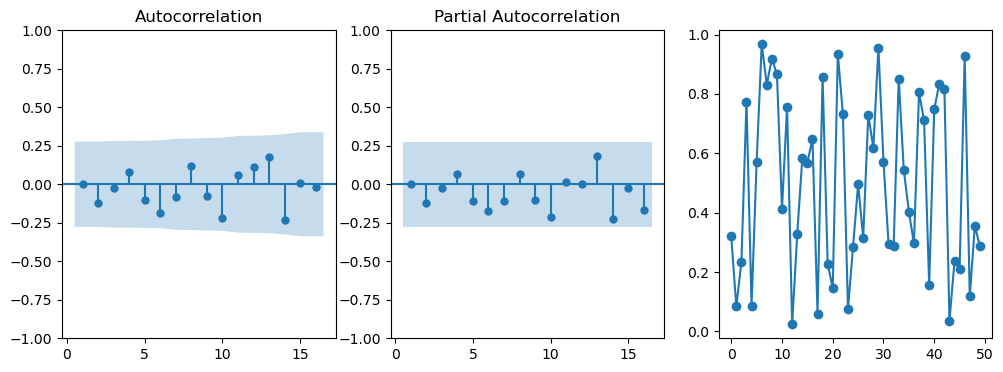

(test points) Runs test p-value = 0.3912672792826394 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high


In [28]:
vals = np.random.rand(50)
check_gaussianity(vals,title="test points",plotto=1)
check_randomness(vals,title="test points",plotto=1,layout="h")

## Python utilities
In uppercase the parts that should be changed, according to the specific use context.

In [ ]:
# Import the dataset
data = pd.read_csv('PATH/TO/FILE.CSV')
data.head()

# Stack data into single column
data_stack = data.stack() 

# Break single column data in different samples (ie batching)
m=10 # number of samples
n=4  # observations in each sample
data=np.array(data['COLUMN']).reshape(m,n)
data=pd.DataFrame(data)
data.head()

# Change all columns names
new_columns = ['new_col1', 'new_col2', 'new_col3']
df.columns = new_columns
# Change specific columns names
df = df.rename(columns={'col1': 'new_col1', 'col2': 'new_col2'})

# When axis=0 is specified, the operation is performed along the rows (i.e., column by column).
# When axis=1 is specified, the operation is performed along the columns (i.e., row by row).

# ■ SPC iid (Lab 6)

<!-- ## XbarR -->
## Case n>1
<!-- Used for the case n>1 with estimated parameters.   -->
So here data.head() will give a matrix of data, where each row is a sample, and inside each row there are the n observations for that sample.

In [8]:
data = pd.read_csv("./Lab6/ESE06_ex1.csv")
data.head()

,x1,x2,x3,x4,x5
0,10.10,10.04,10.13,9.98,10.14
1,10.28,10.13,9.78,9.94,9.83
2,9.95,10.36,9.90,9.96,9.96
3,9.88,9.89,9.98,9.74,10.14
4,10.12,9.83,10.14,9.81,9.86


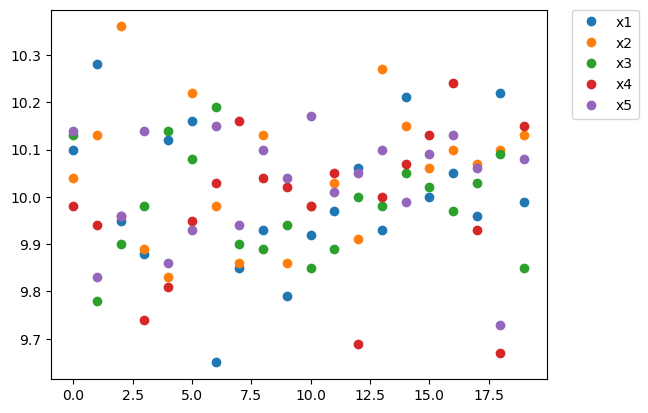

In [9]:
# Scatter plot of all the columns against the index
plt.plot(data['x1'], linestyle='none', marker='o', label = 'x1')
plt.plot(data['x2'], linestyle='none', marker='o', label = 'x2')
plt.plot(data['x3'], linestyle='none', marker='o', label = 'x3')
plt.plot(data['x4'], linestyle='none', marker='o', label = 'x4')
plt.plot(data['x5'], linestyle='none', marker='o', label = 'x5')
# place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

1. There should not be strange patterns or outliers (otherwise go to SPC non iid section), between the samples (so going horizontally morally) and witihin the samples (so checking vertically).  
2. We might also check randomness **but** we would need to know the within-sample order!  
If we knew it we can just stack the data and check randomness assumption on the big vector generated.
3. So we just check normality, on all data points (ie stacking them, getting the big vector mentioned also in point 2).

### Box Cox
If we dont have normality we transform the data using Box Cox.
$$x_{BC,i} = \left\{ \begin{array}{ll} \frac{x_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\ \ln x_i & \text{if } \lambda = 0 \end{array} \right.$$

In [30]:
data_stack = data.stack()

# Box-Cox transformation and return the transformed data
[data_BC, lmbda] = stats.boxcox(data_stack)
print('Lambda = %.3f' % lmbda)
# Use this if we want to set the lambda manually
data_BC = stats.boxcox(data_stack, lmbda=CHOSEN_VALUE)

# Use this to find the best value of lambda for the transformation
fig = plt.figure()
ax = fig.add_subplot(111)
stats.boxcox_normplot(data_stack, -2, 2, plot=ax)
ax.grid(True)

# Come back to the original structure of the dataset, ie unstack the data
data_BC_unstack = data_BC.reshape(data.shape)
# and convert it to a DataFrame
data_BC = pd.DataFrame(data_BC_unstack, columns = data.columns)

### XbarR

In [ ]:
# Create the control chart with the data
data_XR = qda.ControlCharts.XbarR(data)

# with different alpha/k
alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2)
data_XR_alpha = qda.ControlCharts.XbarR(data, K = K_alpha)

### Manually
 **$\mathbf{\bar{X}}$ chart**:
 - $UCL = \overline{\overline{X}} + z_{\alpha/2} \frac{1}{d_2 \sqrt{n}} \overline{R}$
 - $CL = \overline{\overline{X}}$
 - $LCL = \overline{\overline{X}} - z_{\alpha/2} \frac{1}{d_2 \sqrt{n}} \overline{R}$

 **$R$ chart**:
 - $UCL = \overline{R} + z_{\alpha/2} \frac{d_3}{d_2} \overline{R}$
 - $CL = \overline{R}$
 - $LCL = max(0;\ \overline{R} - z_{\alpha/2} \frac{d_3}{d_2} \overline{R})$

      x1     x2     x3    x4     x5  sample_mean  sample_range
0  10.10  10.04  10.13  9.98  10.14       10.078          0.16
1  10.28  10.13   9.78  9.94   9.83        9.992          0.50
2   9.95  10.36   9.90  9.96   9.96       10.026          0.46
3   9.88   9.89   9.98  9.74  10.14        9.926          0.40
4  10.12   9.83  10.14  9.81   9.86        9.952          0.33
Mean of the sample mean: 10.008
Mean of the sample range: 0.314


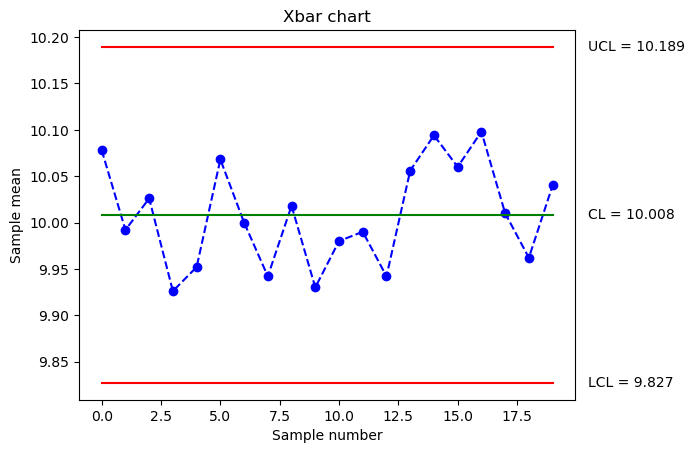

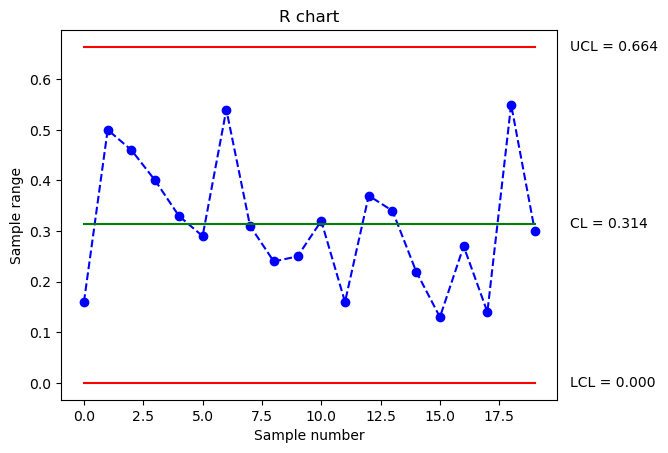

In [43]:
# Make a copy of the data
data_XR = data.copy()
# Add a column with the mean of the rows
data_XR['sample_mean'] = data.mean(axis=1)
# Add a column with the range of the rows
data_XR['sample_range'] = data.max(axis=1) - data.min(axis=1)

# Inspect the dataset
print(data_XR.head())

Xbar_mean = data_XR['sample_mean'].mean() # grand mean
R_mean = data_XR['sample_range'].mean()

print('Mean of the sample mean: %.3f' % Xbar_mean)
print('Mean of the sample range: %.3f' % R_mean)

alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2)

# Vd tabella alla fine per valori
n = 5
A2 = 0.577
D3 = 0
D4 = 2.114

# Now we can compute the CL, UCL and LCL for Xbar and R
data_XR['Xbar_CL'] = Xbar_mean
data_XR['Xbar_UCL'] = Xbar_mean + A2 * R_mean
data_XR['Xbar_LCL'] = Xbar_mean - A2 * R_mean

data_XR['R_CL'] = R_mean
data_XR['R_UCL'] = D4 * R_mean
data_XR['R_LCL'] = D3 * R_mean

data_XR['Xbar_TEST1'] = np.where((data_XR['sample_mean'] > data_XR['Xbar_UCL']) | 
                (data_XR['sample_mean'] < data_XR['Xbar_LCL']), data_XR['sample_mean'], np.nan)
data_XR['R_TEST1'] = np.where((data_XR['sample_range'] > data_XR['R_UCL']) | 
                (data_XR['sample_range'] < data_XR['R_LCL']), data_XR['sample_range'], np.nan)

# Plot the Xbar chart
plt.title('Xbar chart')
plt.plot(data_XR['sample_mean'], color='b', linestyle='--', marker='o')
plt.plot(data_XR['Xbar_UCL'], color='r')
plt.plot(data_XR['Xbar_CL'], color='g')
plt.plot(data_XR['Xbar_LCL'], color='r')
plt.ylabel('Sample mean')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XR)+.5, data_XR['Xbar_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['Xbar_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['Xbar_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['Xbar_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['Xbar_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['Xbar_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XR['Xbar_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# Plot the R chart
plt.title('R chart')
plt.plot(data_XR['sample_range'], color='b', linestyle='--', marker='o')
plt.plot(data_XR['R_UCL'], color='r')
plt.plot(data_XR['R_CL'], color='g')
plt.plot(data_XR['R_LCL'], color='r')
plt.ylabel('Sample range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XR)+.5, data_XR['R_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['R_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['R_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['R_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XR['R_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

### Estimate variance and CI
Variance estimate trhough R:
$$\hat{\sigma} = \frac{\bar{R}}{d_2(n)}$$
CI: $$\bar{X} - z_{\alpha/2} \frac{\hat{\sigma}}{\sqrt{n}} \leq \mu \leq \bar{X} + z_{\alpha/2} \frac{\hat{\sigma}}{\sqrt{n}}$$

In [45]:
# Estimate sigma_hat through R statistic
d2 = qda.constants.getd2(n) # to get d2
sigma_hat = R_mean / d2
print('Sigma_hat = %.3f' % sigma_hat)

# Estimate confidence interval (control limits) 
CI = stats.norm.interval(1-alpha, loc=Xbar_mean, scale=sigma_hat/np.sqrt(n))
print('CI = (%.3f, %.3f)' % CI)

Sigma_hat = 0.135
CI = (9.822, 10.195)


### Table of constants

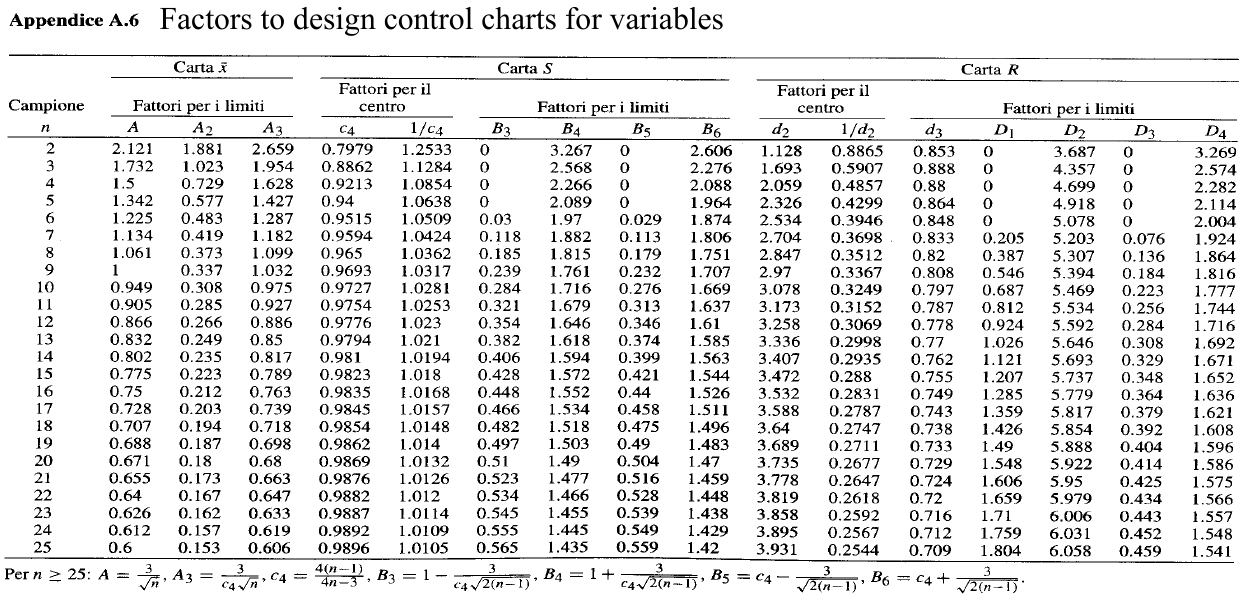

### Operating characteristic curve
$$\beta = P(Z \leq K - \delta \sqrt{n}) - P(Z \leq -K - \delta \sqrt{n})$$

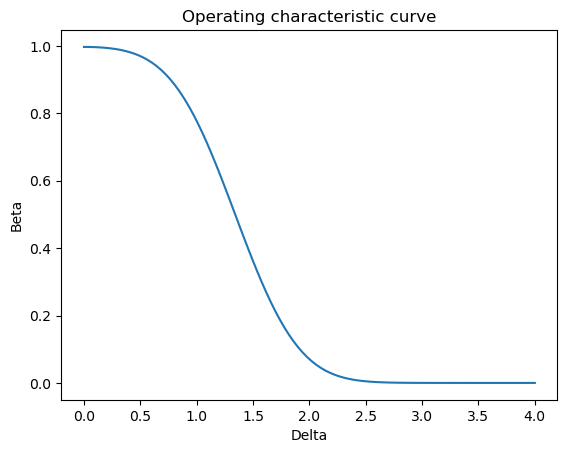

In [41]:
# n=data.shape[1] # maybe this also work
n=SET_N_FROM_DATA
# Define a range of values for beta
delta = np.linspace(0, 4, 100)
# Compute the corresponding beta values
beta = stats.norm.cdf(3 - delta*np.sqrt(n)) - stats.norm.cdf(-3 - delta*np.sqrt(n))
# Plot the beta values
plt.plot(delta, beta)
plt.xlabel('Delta')
plt.ylabel('Beta')
plt.title('Operating characteristic curve')
plt.show()

### ARL curve
ARL is the expected number of samples that we need to wait (on average) before identifying that the process had a shift.
$$ARL = \frac{1}{1-\beta}$$

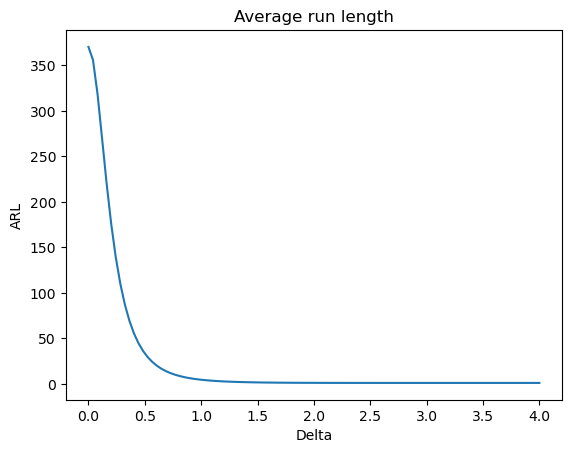

In [34]:
# Average run length ARL
ARL = 1/(1-beta)
# Plot the ARL values
plt.plot(delta, ARL)
plt.xlabel('Delta')
plt.ylabel('ARL')
plt.title('Average run length')
plt.show()

### XbarS

In [ ]:
# X-bar and S charts
data_XS = qda.ControlCharts.XbarS(data)

# with different alpha/k
alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2)
data_XR_alpha = qda.ControlCharts.XbarS(data, K = K_alpha)

### Manually

      x1     x2     x3    x4     x5  sample_mean  sample_std
0  10.10  10.04  10.13  9.98  10.14       10.078    0.067231
1  10.28  10.13   9.78  9.94   9.83        9.992    0.209690
2   9.95  10.36   9.90  9.96   9.96       10.026    0.188361
3   9.88   9.89   9.98  9.74  10.14        9.926    0.147241
4  10.12   9.83  10.14  9.81   9.86        9.952    0.163615
Mean of the sample mean: 10.008
Mean of the sample range: 0.130


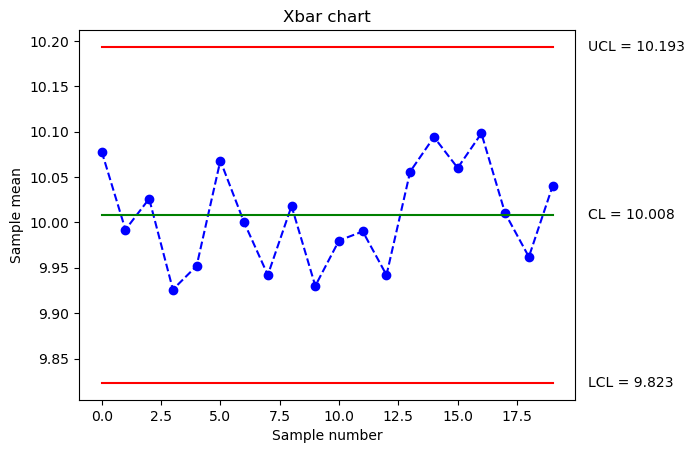

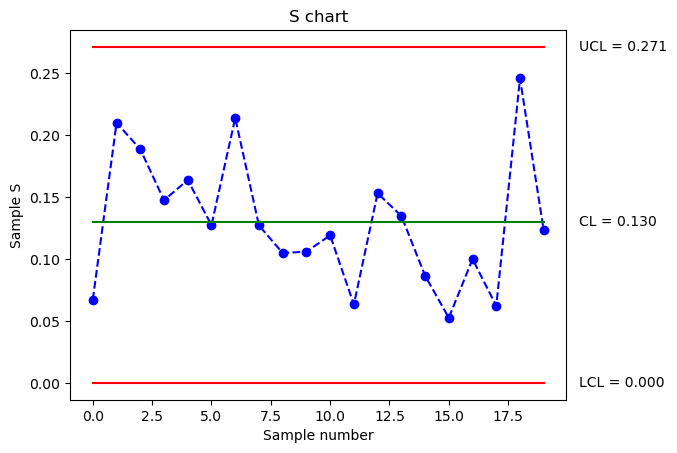

In [47]:
# Make a copy of the data
data_XS = data.copy()
# Add a column with the mean of the rows
data_XS['sample_mean'] = data.mean(axis=1)
# Add a column with the range of the rows
data_XS['sample_std'] = data.std(axis=1)

print(data_XS.head())

Xbar_mean = data_XS['sample_mean'].mean()
S_mean = data_XS['sample_std'].mean()

print('Mean of the sample mean: %.3f' % Xbar_mean)
print('Mean of the sample range: %.3f' % S_mean)

n = data.shape[1]
K = 3
A3 = K * 1 / (qda.constants.getc4(n) * np.sqrt(n))
B3 = np.maximum(1 - K * (np.sqrt(1-qda.constants.getc4(n)**2)) / (qda.constants.getc4(n)), 0)
B4 = 1 + K * (np.sqrt(1-qda.constants.getc4(n)**2)) / (qda.constants.getc4(n))

# Now we can compute the CL, UCL and LCL for Xbar and S
data_XS['Xbar_CL'] = Xbar_mean
data_XS['Xbar_UCL'] = Xbar_mean + A3 * S_mean
data_XS['Xbar_LCL'] = Xbar_mean - A3 * S_mean
data_XS['S_CL'] = S_mean
data_XS['S_UCL'] = B4 * S_mean
data_XS['S_LCL'] = B3 * S_mean
data_XS['Xbar_TEST1'] = np.where((data_XS['sample_mean'] > data_XS['Xbar_UCL']) | 
                (data_XS['sample_mean'] < data_XS['Xbar_LCL']), data_XS['sample_mean'], np.nan)
data_XS['S_TEST1'] = np.where((data_XS['sample_std'] > data_XS['S_UCL']) | 
                (data_XS['sample_std'] < data_XS['S_LCL']), data_XS['sample_std'], np.nan)
data_XS.head()

# Plot the Xbar chart
plt.title('Xbar chart')
plt.plot(data_XS['sample_mean'], color='b', linestyle='--', marker='o')
plt.plot(data_XS['Xbar_UCL'], color='r')
plt.plot(data_XS['Xbar_CL'], color='g')
plt.plot(data_XS['Xbar_LCL'], color='r')
plt.ylabel('Sample mean')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XS)+.5, data_XS['Xbar_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XS['Xbar_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['Xbar_CL'].iloc[0], 'CL = {:.3f}'.format(data_XS['Xbar_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['Xbar_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XS['Xbar_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XS['Xbar_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# Plot the S chart
plt.title('S chart')
plt.plot(data_XS['sample_std'], color='b', linestyle='--', marker='o')
plt.plot(data_XS['S_UCL'], color='r')
plt.plot(data_XS['S_CL'], color='g')
plt.plot(data_XS['S_LCL'], color='r')
plt.ylabel('Sample S')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XS)+.5, data_XS['S_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XS['S_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['S_CL'].iloc[0], 'CL = {:.3f}'.format(data_XS['S_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['S_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XS['S_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XS['S_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

## Case n=1
So no we deal with individual data.

In [54]:
data = pd.read_csv("./Lab6/ESE06_ex3.csv")
COL_NAME = "GM"
data.head()

,GM
0,-0.875
1,2.437
2,-1.187
3,-2.063
4,0.938


1. Verify randomness assumption.
2. Verify normality assumption.

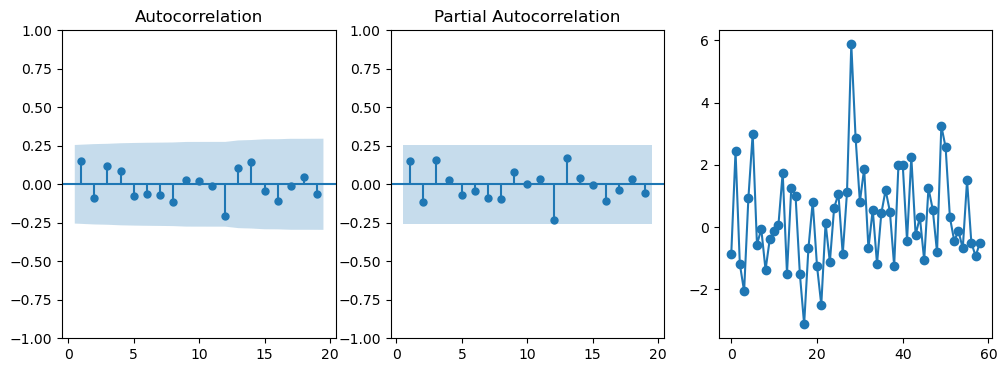

() Runs test p-value = 0.8793778294331255 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high


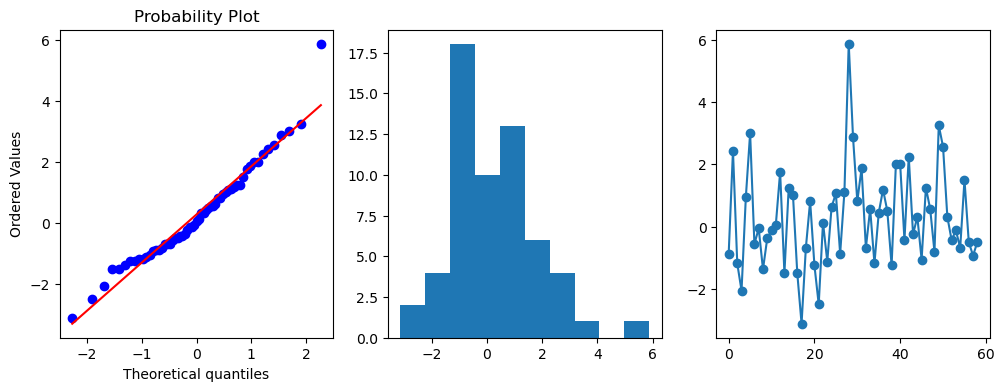

() Normality p-value = 0.06757929176092148 - Normality at alpha 5%? True
H0 is "data are not gaussian" => conclusion is good if pvalue is high


In [51]:
check_randomness(data[COL_NAME])
check_gaussianity(data[COL_NAME])

### IMR

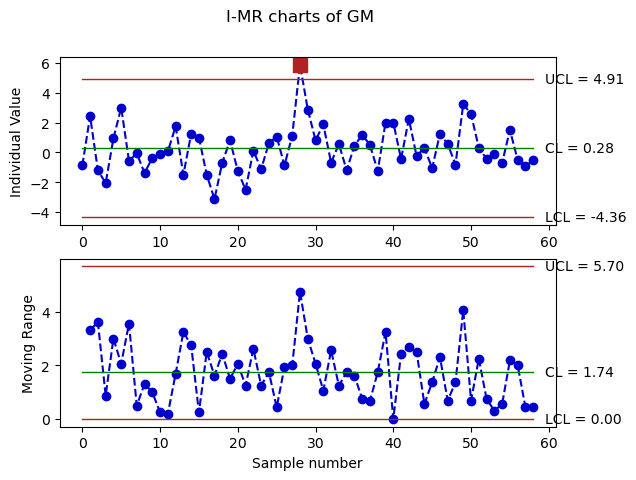

In [59]:
data_IMR = qda.ControlCharts.IMR(data, COL_NAME)

### Manually

In [55]:
# Compute the moving ranges using the diff function
data['MR'] = data['GM'].diff().abs()
# Print out descriptive statistics of MR and time
data.describe()

,GM,MR
count,59.000000,58.000000
mean,0.275424,1.743603
std,1.581153,1.091674
min,-3.125000,0.000000
25%,-0.844000,0.749500
50%,0.062000,1.718500
75%,1.156500,2.484500
max,5.875000,4.750000


Now we can proceed with the charts.  
 **I chart**:
 - $UCL = \bar{x} + 3 \left(\frac{\bar{MR}}{d_2} \right)$
 - $CL = \bar{x}$
 - $LCL = \bar{x} - 3 \left(\frac{\bar{MR}}{d_2} \right)$
 
 **MR chart**:
 - $UCL = D_4 \bar{MR}$
 - $CL = \bar{MR}$
 - $LCL = 0$

       I     MR
0 -0.875    NaN
1  2.437  3.312
2 -1.187  3.624
3 -2.063  0.876
4  0.938  3.001
       I     MR     I_UCL      I_CL     I_LCL    MR_UCL     MR_CL  MR_LCL  \
0 -0.875    NaN  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
1  2.437  3.312  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
2 -1.187  3.624  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
3 -2.063  0.876  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
4  0.938  3.001  4.912667  0.275424 -4.361819  5.696352  1.743603       0   

   I_TEST1  MR_TEST1  
0      NaN       NaN  
1      NaN       NaN  
2      NaN       NaN  
3      NaN       NaN  
4      NaN       NaN  


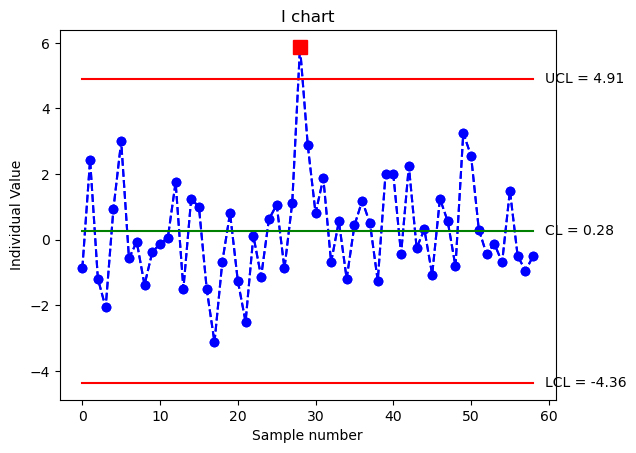

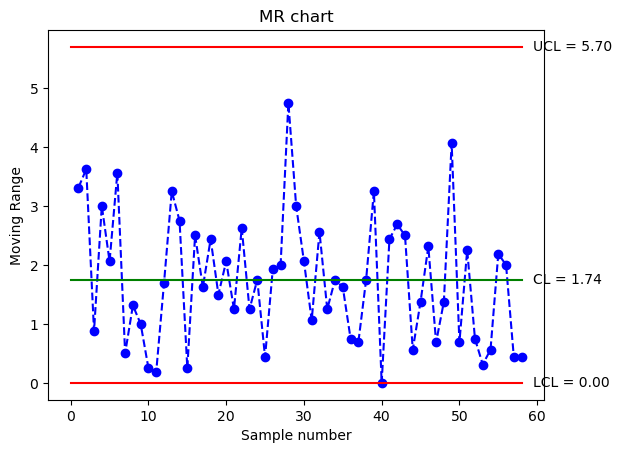

In [57]:
# Define the control limits (with n=2)
d2 = 1.128 
D4 = 3.267

# make a copy of the data
df = data.copy()
# change the name of the column time to I
df.rename(columns={COL_NAME:'I'}, inplace=True)

print(df.head())

# Create columns for the upper and lower control limits
df['I_UCL'] = df['I'].mean() + (3*df['MR'].mean()/d2)
df['I_CL'] = df['I'].mean()
df['I_LCL'] = df['I'].mean() - (3*df['MR'].mean()/d2)
df['MR_UCL'] = D4 * df['MR'].mean()
df['MR_CL'] = df['MR'].mean()
df['MR_LCL'] = 0
# Define columns for possible violations of the control limits
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | 
                (df['I'] < df['I_LCL']), df['I'], np.nan)
df['MR_TEST1'] = np.where((df['MR'] > df['MR_UCL']) | 
                (df['MR'] < df['MR_LCL']), df['MR'], np.nan)

print(df.head())

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.2f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# MR chart
plt.title('MR chart')
plt.plot(df['MR'], color='b', linestyle='--', marker='o')
plt.plot(df['MR_UCL'], color='r')
plt.plot(df['MR_CL'], color='g')
plt.plot(df['MR_LCL'], color='r')
plt.ylabel('Moving Range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['MR_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['MR_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_CL'].iloc[0], 'CL = {:.2f}'.format(df['MR_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['MR_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

### OOC signaled
What to do?  
- if we have an assignable cause: the data violating the charts was really out of control, so we should remove it and redesign the chart (as phase 1 assumes to be working only with in control data). 
- if no assignable cause: do nothing, it was a false alarm. It can happen. In case we want really to remove it we can tune the alpha, ie the K defining the widht of the charts.

In [60]:
# find the index of the I_TEST1 column different from NaN -> ooc value index
OOC_idx = np.where(data_IMR['I_TEST1'].notnull())[0]

print('The index of the OOC point is: {}'.format(OOC_idx))

The index of the OOC point is: [28]


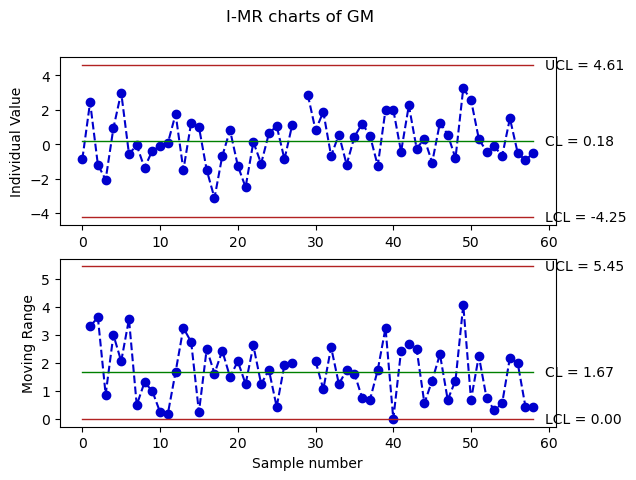

In [64]:
# New control chart without ooc value
# only if assignable cause, iterative procedure
data_2 = data.copy()
# replace the OOC point with NaN
data_2[COL_NAME].iloc[OOC_idx] = np.nan
# Plot the new control chart
data_IMR_2 = qda.ControlCharts.IMR(data_2, COL_NAME)

### Adding new observations

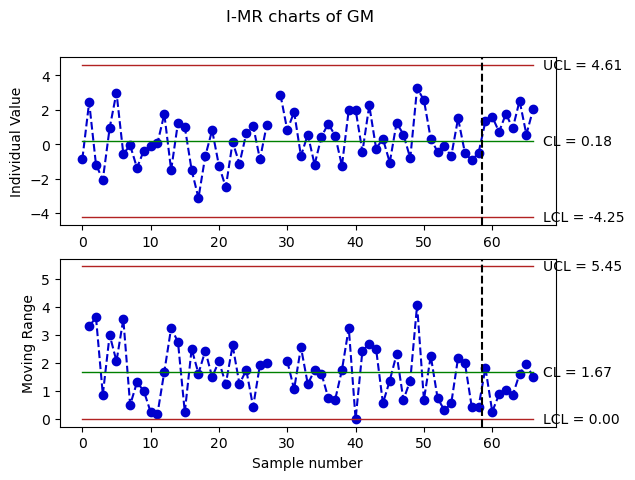

In [68]:
# Import the dataset
data = pd.read_csv('./Lab6/ESE06_ex3.csv')
# replace the OOC point with NaN
data[COL_NAME].iloc[OOC_idx] = np.nan

# Define the array with the new observations
new_obs = np.array((1.327, 1.594, 0.716, 1.767, 0.915, 2.524, 0.563, 2.053))
# Add the new observations to the dataset
new_data = pd.concat([data, pd.DataFrame(new_obs, columns=['GM'])], ignore_index=True)

# Use the parameter `subset_size` to specify the number of observations to be used 
# for the computation of the control limits (Phase 1 data).
new_data_IMR = qda.ControlCharts.IMR(new_data, 'GM', subset_size=len(data))
# chart built only on old data, but new data plotted to see if in control
# black dotted line to separate old and new obs

# ■ SPC non iid (Lab 7)